# 1. Explore Graph Database Using Cypher Code

## Find All References for an Episode

In [1]:
from neo4j import GraphDatabase
import os
from dotenv import load_dotenv

# Load credentials from .env
load_dotenv()
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USER')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

## Find Related Episodes

In [14]:
EPISODE_NUM = 437
with driver.session() as session:
    result = session.run("""
        MATCH (e:Episode {episode_number: $ep_num})-[:REFERENCES]->(r)<-[:REFERENCES]-(other:Episode)
        WHERE other.episode_number <> $ep_num
        RETURN other.episode_number, other.title, count(*) AS shared_refs
        ORDER BY shared_refs DESC
        LIMIT 5
    """, ep_num=EPISODE_NUM)
    for record in result:
        print(record)

<Record other.episode_number=438 other.title='Naruhodo #438 - O termo "macho alfa" faz sentido? - Parte 2 de 2' shared_refs=34>
<Record other.episode_number=228 other.title='Todos Nos Enxergamos As Mesmas Cores Parte 2 De 2' shared_refs=2>
<Record other.episode_number=284 other.title='Qual O Impacto Do Desemprego Em Nossa Vida' shared_refs=2>
<Record other.episode_number=242 other.title='O Experimento Do Parque Dos Ratos Ainda E Valido' shared_refs=2>
<Record other.episode_number=430 other.title='Naruhodo #430 - Por que é tão difícil deixar o rancor de lado?' shared_refs=2>


## Compute Average Embeddings for Each Episode

In [15]:
import numpy as np

def get_episode_embeddings(driver):
    episode_embeddings = {}
    with driver.session() as session:
        result = session.run("""
            MATCH (e:Episode)-[:HAS_SEGMENT]->(s:TranscriptSegment)
            RETURN e.episode_number AS episode, s.embedding AS embedding
        """)
        for record in result:
            ep = record['episode']
            emb = record['embedding']
            if emb is not None:
                if ep not in episode_embeddings:
                    episode_embeddings[ep] = []
                episode_embeddings[ep].append(emb)
    # Compute average embedding for each episode, only if there are valid embeddings
    avg_embeddings = {}
    for ep, embs in episode_embeddings.items():
        valid_embs = [e for e in embs if e is not None]
        if valid_embs:
            avg_embeddings[ep] = np.mean(np.array(valid_embs), axis=0)
    return avg_embeddings

avg_embeddings = get_episode_embeddings(driver)

In [16]:
for ep, emb in list(avg_embeddings.items())[:100]:
    print(f"Episode {ep}: embedding shape {np.array(emb).shape}")

Episode 4: embedding shape (384,)
Episode 11: embedding shape (384,)
Episode 13: embedding shape (384,)
Episode 17: embedding shape (384,)
Episode 19: embedding shape (384,)
Episode 20: embedding shape (384,)
Episode 33: embedding shape (384,)
Episode 60: embedding shape (384,)
Episode 61: embedding shape (384,)
Episode 65: embedding shape (384,)
Episode 74: embedding shape (384,)
Episode 78: embedding shape (384,)
Episode 83: embedding shape (384,)
Episode 87: embedding shape (384,)
Episode 88: embedding shape (384,)
Episode 89: embedding shape (384,)
Episode 94: embedding shape (384,)
Episode 96: embedding shape (384,)
Episode 98: embedding shape (384,)
Episode 103: embedding shape (384,)
Episode 107: embedding shape (384,)
Episode 108: embedding shape (384,)
Episode 109: embedding shape (384,)
Episode 111: embedding shape (384,)
Episode 113: embedding shape (384,)
Episode 115: embedding shape (384,)
Episode 116: embedding shape (384,)
Episode 119: embedding shape (384,)
Episode 120:

**Shape (384,)**

- Each embedding vector contains 384 dimensions.
- This is expected when using models like `sentence-transformers/all-MiniLM-L6-v2`, which produce 384-dimensional outputs.
- This confirms that the embeddings are correctly sized.

**The values are the same for all episodes**

- If the **values** of the average embedding (not just the shape) are identical across all episodes, this indicates a serious issue.
- Possible causes include:
  - The same embedding is being stored for every transcript segment.
  - The embedding code is not using the actual transcript content.
  - There is a bug in the embedding import process.
  - Transcript segments are empty or identical.


**Printing instances of episodes embeddings to make sure that the embeddings are not repeating**

In [17]:
for ep, emb in list(avg_embeddings.items())[:5]:
    print(f"Episode {ep}: first 5 values {emb[:5]}")

Episode 4: first 5 values [-0.02746016  0.01886117 -0.03845078 -0.06112876 -0.05460436]
Episode 11: first 5 values [ 0.01941053  0.0391253  -0.0335583  -0.0775647  -0.07263891]
Episode 13: first 5 values [-0.01252141  0.01511657 -0.0203701  -0.03983657 -0.04709581]
Episode 17: first 5 values [ 0.00262913  0.0320074  -0.0342453  -0.05298897 -0.09224672]
Episode 19: first 5 values [-0.00444996  0.01033241 -0.0323885  -0.05985431 -0.03789899]


**Embedding Value Check**

- The fact that the first few values of the average embedding vector differ across episodes indicates that embeddings are being computed correctly.
- This suggests the model is capturing the unique content of each episode’s transcript.

**What This Means**

- The shape `(384,)` confirms the correct dimensionality from the embedding model.
- Varying values across episodes confirm that the pipeline is functioning as expected.



# 2. Cosine Similarity

**How It Works**

**Embeddings as Vectors**  
Each episode is represented by a 384-dimensional vector, computed as the average of its transcript segment embeddings. These vectors capture the semantic content of each episode and enable mathematical comparisons.

**Cosine Similarity**  
Cosine similarity measures the angle between two vectors in high-dimensional space:  
- Values close to **1** indicate high similarity (vectors point in the same direction).  
- Values near **0** indicate no relation (orthogonal vectors).  
- Values close to **-1** are rare and indicate opposite meanings.

**Comparison Process**  
For a given `target_episode`, the process is as follows:  
1. Retrieve its average embedding vector.  
2. Compute cosine similarity between this vector and all other episode vectors.  
3. Sort the results by similarity score in descending order.  
4. Return the top N most similar episodes, excluding the target episode itself.

**Interpretation**  
Episodes that discuss similar topics or use similar language will produce vectors that align closely, resulting in high cosine similarity. Conversely, unrelated episodes will have lower similarity scores.

**Use Case**  
Running this comparison for a given episode returns a list of the most content-similar episodes along with their similarity scores. This method is useful for:  
- Recommending related episodes  
- Clustering episodes by theme  
- Exploring the semantic structure of podcast content

**Summary Table**

| Step              | Description                                         |
|-------------------|-----------------------------------------------------|
| Get embeddings    | Represent each episode as a 384-dimensional vector  |
| Cosine similarity | Compare the target episode’s vector with others     |
| Sort & filter     | Return top N most similar episodes (excluding self) |

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_most_similar_episodes(target_episode, avg_embeddings, top_n=5):
    target_emb = avg_embeddings[target_episode].reshape(1, -1)
    all_eps = list(avg_embeddings.keys())
    all_embs = np.stack([avg_embeddings[ep] for ep in all_eps])
    sims = cosine_similarity(target_emb, all_embs)[0]
    sim_scores = list(zip(all_eps, sims))
    sim_scores = sorted(sim_scores, key=lambda x: -x[1])
    # Exclude the episode itself
    sim_scores = [s for s in sim_scores if s[0] != target_episode]
    return sim_scores[:top_n]

# Example usage:
target_episode = 437  # Change as needed
similar_episodes = find_most_similar_episodes(target_episode, avg_embeddings)
print(f"Most similar episodes to {target_episode}:")
for ep, score in similar_episodes:
    print(f"Episode {ep}: similarity {score:.3f}")

Most similar episodes to 437:
Episode 438: similarity 0.973
Episode 140: similarity 0.968
Episode 426: similarity 0.966
Episode 323: similarity 0.965
Episode 259: similarity 0.964


**Interpretation**

Episode 437 shares very similar content with episodes 438, 140, 426, 323, and 259. The high similarity scores (> 0.96) indicate these episodes likely cover closely related topics, confirming that the embedding and similarity pipeline is working correctly.


# 3. Investigating Similarity between episodes



**Visualizing Similarities**

Visualizing embedding vectors in 2D helps identify natural groupings and patterns among episodes based on their content. It allows us to observe how episodes relate to one another in terms of semantic similarity, making clustering results and relationships easier to interpret.

**t-SNE (t-distributed Stochastic Neighbor Embedding)**  
- **Goal**: Preserves local structure — points that are close in high dimensions stay close in 2D/3D.
- **Strengths**:
  - Excellent for visualizing clusters and local groupings.
  - Widely used for embedding visualization (e.g., word vectors, transcript embeddings).
- **Weaknesses**:
  - Computationally intensive and slower on large datasets.
  - Does not preserve global structure.
  - Non-deterministic; results vary between runs.
  - Requires tuning of the “perplexity” parameter.

**UMAP (Uniform Manifold Approximation and Projection)**  
- **Goal**: Preserves both local and some global structure; captures overall shape of the data.
- **Strengths**:
  - Faster and more scalable than t-SNE.
  - Better at maintaining global structure.
  - Deterministic by default (more consistent).
  - Parameters like `n_neighbors` and `min_dist` are easier to interpret.
- **Weaknesses**:
  - May "over-cluster" — showing structure where there may be none.
  - Slightly newer than t-SNE, but now widely adopted.

**Summary Table**

| Feature           | t-SNE                  | UMAP                            |
|-------------------|------------------------|----------------------------------|
| Preserves         | Local structure        | Local + some global structure   |
| Speed             | Slower                 | Faster                          |
| Scalability       | Small/medium datasets  | Small to very large datasets    |
| Consistency       | Non-deterministic      | Deterministic (by default)      |
| Global structure  | Not preserved          | Partially preserved             |
| Parameters        | Perplexity             | n_neighbors, min_dist           |

**Which Should You Use?**  
- **Use UMAP** for fast, interpretable, and scalable visualizations — a great first choice.  
- **Use t-SNE** for more detailed, cluster-focused views — especially with smaller datasets.


**Approach**

We will apply both t-SNE and UMAP to the episode embeddings and compare their results to evaluate how each method reveals the structure and relationships among episodes.


## Prepare Data

In [19]:
import numpy as np
import pandas as pd

# Prepare a DataFrame with episode numbers and their average embeddings
episodes = list(avg_embeddings.keys())
embeddings = np.stack([avg_embeddings[ep] for ep in episodes])
df_emb = pd.DataFrame({'episode': episodes})

## Clustering Episodes with KMeans


We will apply KMeans to group episodes based on the similarity of their transcript embeddings. The resulting clusters will be used to color the embedding plots, helping to visualize content-based groupings among episodes.


In [20]:
from sklearn.cluster import KMeans

n_clusters = 10  # You can experiment with this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_emb['cluster'] = kmeans.fit_predict(embeddings)
color_field = 'cluster'

## t-SNE Visualization

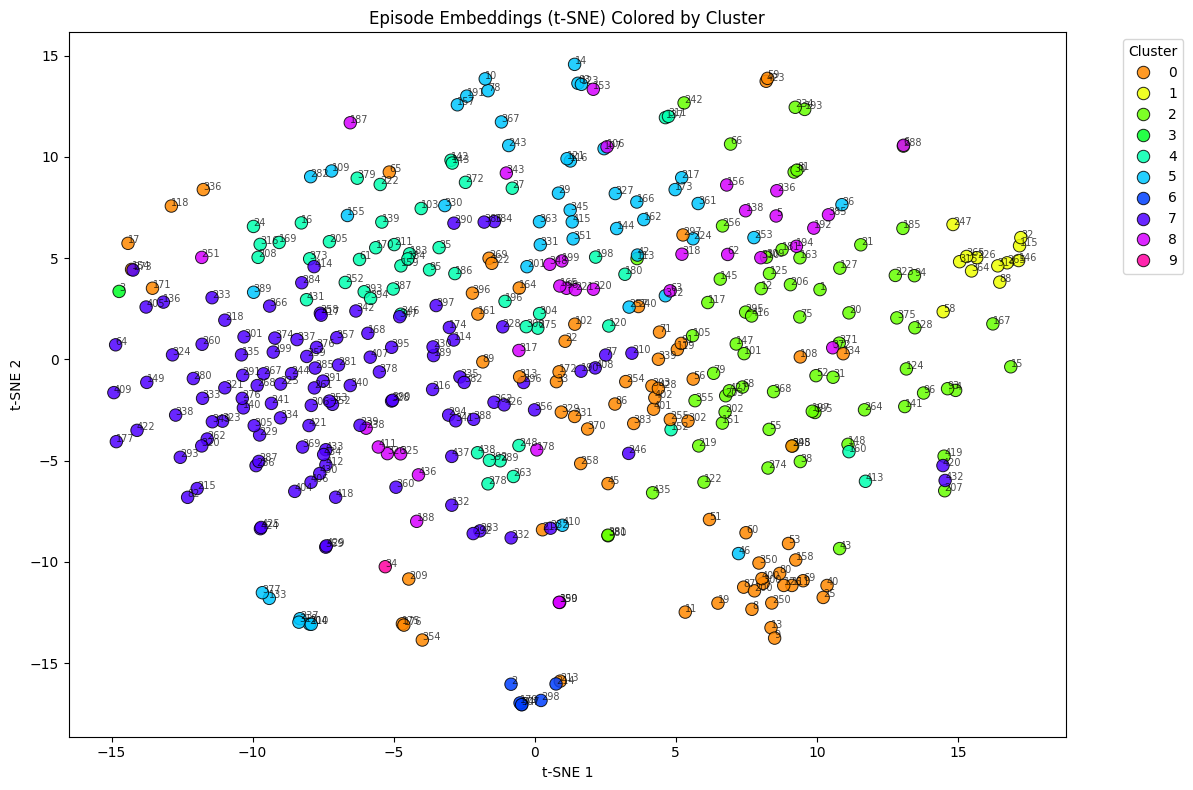

In [21]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
emb_2d_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(df_emb[color_field].unique()))
sns.scatterplot(
    x=emb_2d_tsne[:,0], y=emb_2d_tsne[:,1],
    hue=df_emb[color_field],
    palette=palette,
    s=80, alpha=0.85, edgecolor='k', legend='full'
)
for i, ep in enumerate(episodes):
    plt.text(emb_2d_tsne[i,0], emb_2d_tsne[i,1], str(ep), fontsize=7, alpha=0.7)
plt.title(f"Episode Embeddings (t-SNE) Colored by {color_field.capitalize()}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title=color_field.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## UMAP Visualization

c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


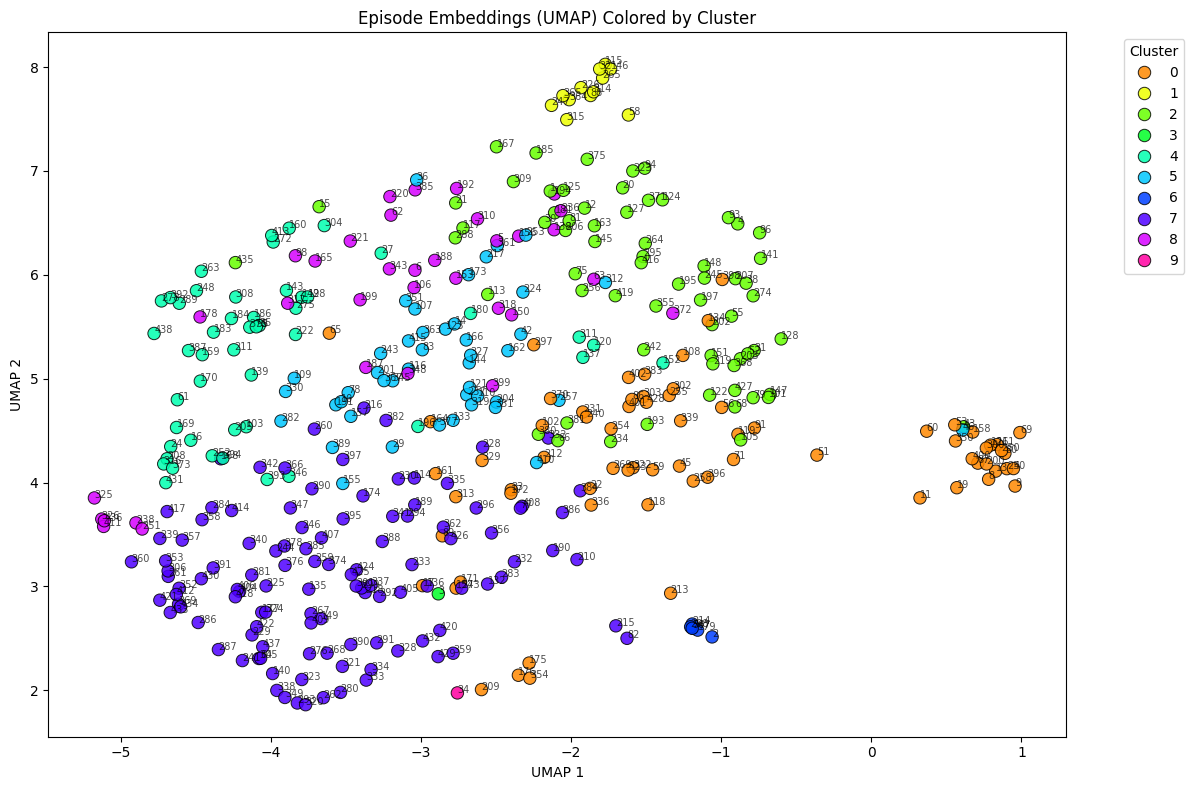

In [22]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
emb_2d_umap = umap_model.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(df_emb[color_field].unique()))
sns.scatterplot(
    x=emb_2d_umap[:,0], y=emb_2d_umap[:,1],
    hue=df_emb[color_field],
    palette=palette,
    s=80, alpha=0.85, edgecolor='k', legend='full'
)
for i, ep in enumerate(episodes):
    plt.text(emb_2d_umap[i,0], emb_2d_umap[i,1], str(ep), fontsize=7, alpha=0.7)
plt.title(f"Episode Embeddings (UMAP) Colored by {color_field.capitalize()}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title=color_field.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interpretation**

- Each point represents an episode, positioned so that episodes with similar transcript content appear close together.
- Comparing the t-SNE and UMAP plots helps assess whether clusters or patterns are consistent across methods.
- Coloring points by metadata (e.g., episode type, year) can reveal additional insights and thematic groupings.


### Listing Episodes in Each Cluster

In [23]:
for c in sorted(df_emb['cluster'].unique()):
    episodes_in_cluster = df_emb[df_emb['cluster'] == c]['episode'].tolist()
    print(f"Cluster {c}: Episodes {episodes_in_cluster}")

Cluster 0: Episodes [11, 13, 17, 19, 33, 60, 65, 87, 89, 108, 111, 119, 126, 154, 158, 161, 164, 171, 172, 175, 176, 200, 209, 212, 213, 231, 240, 254, 255, 258, 269, 297, 300, 302, 303, 313, 322, 329, 336, 339, 350, 354, 370, 383, 396, 398, 400, 401, 402, 423, 428, 22, 25, 40, 45, 51, 53, 56, 59, 69, 71, 80, 86, 91, 102, 118, 134, 250, 8, 9]
Cluster 1: Episodes [88, 115, 146, 226, 247, 265, 314, 315, 364, 365, 32, 58]
Cluster 2: Episodes [4, 20, 94, 96, 113, 122, 124, 127, 128, 141, 147, 148, 151, 163, 167, 181, 185, 193, 195, 197, 202, 203, 206, 207, 219, 223, 234, 242, 245, 12, 256, 264, 274, 288, 295, 309, 355, 368, 371, 375, 380, 381, 416, 419, 427, 435, 15, 21, 30, 31, 38, 43, 52, 55, 66, 68, 75, 79, 81, 93, 101, 105, 117, 125, 145, 1]
Cluster 3: Episodes [3]
Cluster 4: Episodes [61, 103, 120, 137, 139, 142, 143, 152, 159, 160, 169, 170, 180, 183, 184, 186, 196, 198, 205, 208, 211, 222, 248, 252, 263, 272, 275, 278, 289, 304, 308, 311, 316, 346, 373, 379, 387, 392, 393, 394, 413,

**Next Step: Understanding Clusters**

It's unclear why these episodes were grouped into the same cluster. To gain better insight, I will use a Large Language Model (LLM) to summarize the main topics of each cluster and help interpret the underlying themes.


### Set up your OpenAI API key

In [26]:
import openai
import os

# Set your OpenAI API key
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI(api_key=api_key) 

### Define a function to get a summary for a cluster

In [27]:
def get_segments_3_to_6(ep_num):
    with driver.session() as session:
        result = session.run("""
            MATCH (e:Episode {episode_number: $ep_num})-[:HAS_SEGMENT]->(s:TranscriptSegment)
            WHERE s.chunk_index >= 3 AND s.chunk_index <= 6
            RETURN s.chunk_index AS idx, s.text AS text
            ORDER BY s.chunk_index
        """, ep_num=ep_num)
        return [record['text'] for record in result]

def summarize_theme_intro(segments, model="gpt-4o-mini-2024-07-18", max_tokens=2000):
    prompt = (
        # =====  ROLE & CONTEXT =====
    "You are an expert podcast analyst.\n"
    "The input is a **cluster** of podcast episodes that were grouped together by transcript similarity.\n\n"

    # =====  TASK =====
    "Your job has two steps:\n"
    "1. **Cluster summary** – Write **1–2 crisp sentences** that capture the overarching theme shared by these episodes.\n"
    "2. **Topic table** – Create a **markdown table** with exactly two columns: `Topic` and `Description`.\n"
    "   • Each row must be a distinct topic or sub‑topic discussed in the cluster.\n"
    "   • Keep descriptions short (≤ 12 words) and written in sentence case.\n\n"

    # =====  RULES =====
    "• Ignore sponsorships, program notes, host chit‑chat, or generic show intros.\n"
    "• Do **not** speculate beyond the provided text.\n"
    "• Output **only** the summary followed by the table—no extra commentary.\n\n"

    # =====  EXAMPLE FORMAT =====
    "Example table format (do not include this example in your answer):\n"
    "| Topic | Description |\n"
    "|-------|-------------|\n"
    "| Neuroplasticity | How the brain changes in response to experience. |\n"
    "| Memory formation | Mechanisms of creating and storing memories. |\n"
    "| Brain injuries | Effects and recovery from brain trauma. |\n\n"

    # =====  INPUT SEGMENTS =====
    "### Podcast transcript segments START ###\n"
    + "\n".join(segments) +
    "\n### Podcast transcript segments END ###\n\n"

    # =====  BEGIN ANSWER =====
    "### Summary\n"
    "(Write here)\n\n"
    "### Topics Table\n"
    )
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens,
        temperature=0.2,
    )
    return response.choices[0].message.content.strip()


### Generate and print summaries for each cluster


In [28]:
# Number of episodes to sample per cluster (adjust as needed)
episodes_per_cluster = 10

for c in sorted(df_emb['cluster'].unique()):
    episodes_in_cluster = df_emb[df_emb['cluster'] == c]['episode'].tolist()
    segments = []
    for ep in episodes_in_cluster[:episodes_per_cluster]:
        segs = get_segments_3_to_6(ep)
        # Optionally, limit each segment to 500 chars to fit token limits
        segments.extend([s[:500] for s in segs if s])
    if segments:
        print(f"\nCluster {c} summary:")
        summary = summarize_theme_intro(segments)
        print(summary)
    else:
        print(f"\nCluster {c}: No transcript segments found.")


Cluster 0 summary:
### Summary
This cluster of podcast episodes explores various scientific curiosities, including language, perception, and psychological phenomena, while emphasizing the importance of critical thinking and inclusivity in discussions.

### Topics Table
| Topic | Description |
|-------|-------------|
| Manga reading habits | Impact of reading direction on proficiency. |
| Writing systems | Evolution of Japanese and Western writing styles. |
| Hair growth | Intrinsic factors affecting hair development. |
| Inclusivity in media | Making content accessible for visually impaired audiences. |
| Probability theory | Understanding lottery odds and decision-making. |
| Confirmation bias | How beliefs shape perception and social media behavior. |
| Optical illusions | The science behind visual perception and interpretation. |
| Sleep paralysis | Physiological explanations for waking paralysis experiences. |
| Allergies vs. colds | Distinguishing between allergic reactions and v

**Cluster Summaries**

With a summary generated for each cluster, it's now possible to better understand the main theme or topic represented by each group of episodes.


### How to decide which similiarity visualization technique is "better"

**Evaluating Which Visualization Is Better**

**1. Understand What “Better” Means for Your Use Case**

**Goal**: Ensure the 2D plot reflects the true relationships between episode clusters and is easy to interpret.  
“Better” may refer to:
- Clusters appearing well-separated and compact in 2D.
- Alignment between the 2D structure and KMeans clusters from the original high-dimensional space.
- A visualization that is stable and easy to interpret.

**2. Technical Ways to Compare t-SNE and UMAP**

**A. Cluster Separation and Compactness**

- **Visual**:
  - Do KMeans clusters form distinct, non-overlapping groups?
  - Are episodes within the same cluster positioned close together?

- **Quantitative**:
  - Use a clustering metric like **silhouette score** based on the 2D coordinates and KMeans labels.
  - A **higher silhouette score** indicates better cluster separation and compactness.
  - If UMAP yields a higher score, it is quantitatively more effective at preserving cluster structure.

**B. Preservation of Local and Global Structure**

- **t-SNE** preserves **local structure** well but often distorts global relationships.
- **UMAP** captures both **local** and some **global** structure, making inter-cluster distances more meaningful.

**C. Stability and Reproducibility**

- **UMAP** is **deterministic** (consistent results across runs).
- **t-SNE** is **non-deterministic** by default (results may vary unless seeded).

**D. Human Interpretability**

- The most useful visualization is often the one that makes the most sense to **you or your audience**.
- Share both plots with a **colleague or domain expert** to see which better communicates the cluster structure.

**3. Summary Table**

| Criterion              | t-SNE               | UMAP              |
|------------------------|---------------------|-------------------|
| Local structure        | Excellent           | Excellent         |
| Global structure       | Poor                | Good              |
| Cluster separation     | Good (visually)     | Good (visually)   |
| Quantitative evaluation| Use silhouette score| Use silhouette score |
| Stability              | Non-deterministic   | Deterministic     |
| Speed/scalability      | Slower              | Faster            |


### Printing Silhouete Score for t-SNE and UMAP

In [32]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for t-SNE projection
sil_tsne = silhouette_score(emb_2d_tsne, df_emb['cluster'])
print(f"t-SNE silhouette score: {sil_tsne:.3f}")

# Compute silhouette score for UMAP projection
sil_umap = silhouette_score(emb_2d_umap, df_emb['cluster'])
print(f"UMAP silhouette score: {sil_umap:.3f}")

# Interpretation tip:
if sil_tsne > sil_umap:
    print("t-SNE provides better cluster separation in 2D for KMeans clusters.")
elif sil_umap > sil_tsne:
    print("UMAP provides better cluster separation in 2D for KMeans clusters.")
else:
    print("Both methods provide similar cluster separation in 2D.")

t-SNE silhouette score: -0.077
UMAP silhouette score: -0.002
UMAP provides better cluster separation in 2D for KMeans clusters.


**Silhouette Score Interpretation**

Silhouette scores range from -1 to 1:
- **+1**: Clusters are perfectly separated.
- **0**: Clusters are overlapping or ambiguous.
- **Negative**: Many points are likely assigned to the wrong cluster.

**Results**
- **t-SNE**: -0.077  
- **UMAP**: -0.002

**Interpretation**
- Both scores are **negative or near zero**, indicating that the KMeans clusters are **not well-separated** in the 2D projection.
- Many points are positioned closer to other clusters than to their own cluster’s centroid.
- Although UMAP performs slightly better, neither method provides clear separation in 2D space.

**Possible Explanations**
- The **true structure** of the dataset may reside in **higher-dimensional space**.
- As **lossy projections**, t-SNE and UMAP may fail to preserve all cluster characteristics in 2D.
- The **KMeans clustering** may not be optimal, or the chosen number of clusters may not align with the intrinsic structure.
- The **2D projection** may distort separations that are more evident in the original 384-dimensional embedding space.
- Clusters could be **well-separated in the original space**, but this separation is not preserved after dimensionality reduction.


In [30]:
sil_orig = silhouette_score(embeddings, df_emb['cluster'])
print(f"Original embedding silhouette score: {sil_orig:.3f}")

Original embedding silhouette score: 0.031


**Implications of a Low Silhouette Score**

- A silhouette score of **0.031** in the original embedding space indicates that the clusters are **only weakly separated**.
- Most points are nearly as close to other clusters as they are to their own cluster centroid.
- This suggests the clusters are **not well-defined** within the high-dimensional space.

**Potential Use of 3D Visualization**

- In some cases, applying **t-SNE or UMAP in 3D** can help preserve more of the original structure than a 2D projection.
- Even with a low silhouette score, **3D plots** may reveal underlying patterns—particularly when clusters are **stacked or intertwined** in ways that 2D projections obscure.

**Limitations to Consider**

- When the original high-dimensional space exhibits **very weak clustering**, 3D visualizations are unlikely to reveal strong separation.
- These methods can only expose structure that is **already present**; they cannot generate separation where none exists.


### Similarity visualization in 3D

In [34]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


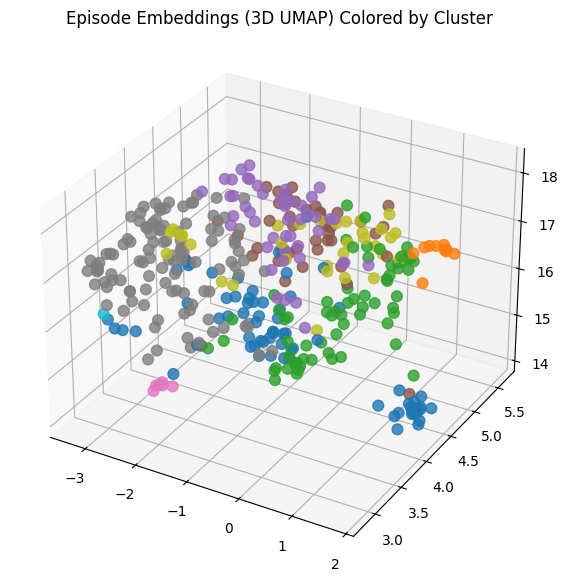

In [35]:
# 3D UMAP
umap_3d = umap.UMAP(n_components=3, random_state=42)
emb_3d_umap = umap_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(emb_3d_umap[:,0], emb_3d_umap[:,1], emb_3d_umap[:,2],
                     c=df_emb['cluster'], cmap='tab10', s=60, alpha=0.8)
ax.set_title("Episode Embeddings (3D UMAP) Colored by Cluster")
plt.show()

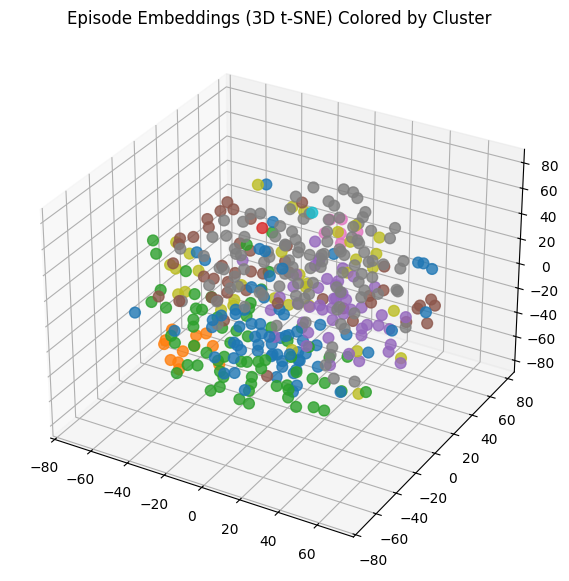

In [36]:
# 3D t-SNE (optional, can be slow)
tsne_3d = TSNE(n_components=3, random_state=42)
emb_3d_tsne = tsne_3d.fit_transform(embeddings)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(emb_3d_tsne[:,0], emb_3d_tsne[:,1], emb_3d_tsne[:,2],
                     c=df_emb['cluster'], cmap='tab10', s=60, alpha=0.8)
ax.set_title("Episode Embeddings (3D t-SNE) Colored by Cluster")
plt.show()

n_clusters=2, silhouette score=0.081
n_clusters=3, silhouette score=0.088
n_clusters=4, silhouette score=0.062
n_clusters=5, silhouette score=0.042
n_clusters=6, silhouette score=0.022
n_clusters=7, silhouette score=0.017
n_clusters=8, silhouette score=0.029
n_clusters=9, silhouette score=0.030
n_clusters=10, silhouette score=0.031
n_clusters=11, silhouette score=0.026
n_clusters=12, silhouette score=0.031
n_clusters=13, silhouette score=0.032
n_clusters=14, silhouette score=0.032
n_clusters=15, silhouette score=0.024
n_clusters=16, silhouette score=0.021
n_clusters=17, silhouette score=0.016
n_clusters=18, silhouette score=0.016
n_clusters=19, silhouette score=0.017
n_clusters=20, silhouette score=0.015


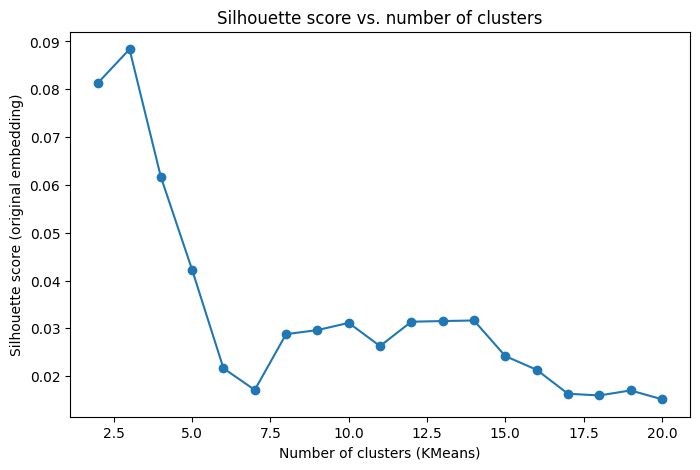

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 21)  # Try from 2 to 20 clusters
scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, cluster_labels)
    scores.append(score)
    print(f"n_clusters={n_clusters}, silhouette score={score:.3f}")

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, scores, marker='o')
plt.xlabel("Number of clusters (KMeans)")
plt.ylabel("Silhouette score (original embedding)")
plt.title("Silhouette score vs. number of clusters")
plt.show()

**Interpretation of Results**

- **Low silhouette scores** (values close to zero) across all tested cluster sizes indicate that the data lacks **strong, well-separated clusters** in the embedding space.
- The **slight decline** in silhouette scores as the number of clusters increases is a common pattern when the data is **not naturally clusterable**.

- The observation that the **podcast themes are multidisciplinary and subjective** is consistent with these findings:
  - Episodes may cover **broad, overlapping topics**.
  - The embeddings capture **subtle and continuous similarities**, rather than forming **distinct, isolated groups**.


## Conclusion


The analysis demonstrates that while transcript embeddings effectively capture semantic similarities between podcast episodes, the overall structure of the data does not exhibit strong, well-separated clusters. 

Both **2D projections** (t-SNE and UMAP) and **quantitative metrics** (silhouette scores) suggest that the content space is **high-dimensional and continuous**, with episodes overlapping in theme rather than forming discrete groups.

This result aligns with the **multidisciplinary and subjective nature** of podcast content, where themes often blend and evolve across episodes. Embeddings still provide value for tasks such as **similarity search**, **thematic exploration**, and **content-based recommendation**, but traditional clustering may offer limited interpretability without complementary methods, such as **LLM-based summarization** or **metadata filtering**.

In practice, the insights from this analysis support using embedding-based tools to navigate episode relationships, while remaining cautious about drawing hard boundaries between thematic clusters.
